<a href="https://colab.research.google.com/github/StevenMElliott/Drug-Price-Project/blob/master/Drug_Prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Data and Libraries



In [0]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

In [0]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
link = 'https://drive.google.com/open?id=1_jslOM6OoNkMVN2Z6dMQuGUm1LN_8vFw'

In [0]:
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='

In [0]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('NADAC__National_Average_Drug_Acquisition_Cost_.csv')  
#The Data
#SOURCE and EXPLAINATION: https://data.medicaid.gov/Drug-Pricing-and-Payment/NADAC-National-Average-Drug-Acquisition-Cost-/a4y5-998d 
master_df = pd.read_csv('NADAC__National_Average_Drug_Acquisition_Cost_.csv')

#Data Exploration

In [6]:
print(master_df.shape)
master_df.head()

(6996156, 12)


,NDC Description,NDC,NADAC_Per_Unit,Effective_Date,Pricing_Unit,Pharmacy_Type_Indicator,OTC,Explanation_Code,Classification_for_Rate_Setting,Corresponding_Generic_Drug_NADAC_Per_Unit,Corresponding_Generic_Drug_Effective_Date,As of Date
0,IBUPROFEN 200 MG TABLET,70000017504,0.02991,11/21/2018,EA,C/I,Y,1,G,NaN,NaN,12/12/2018
1,OXYCODONE HCL ER 80 MG TABLET,115156201,9.02989,11/21/2018,EA,C/I,N,"1, 6",G,NaN,NaN,12/12/2018
2,OXYCODONE HCL 15 MG TABLET,603499128,0.15188,11/21/2018,EA,C/I,N,1,G,NaN,NaN,12/12/2018
3,KETOCONAZOLE 200 MG TABLET,51672402601,1.68457,11/21/2018,EA,C/I,N,1,G,NaN,NaN,12/12/2018
4,NICOTINE 7 MG/24HR PATCH,70000011302,1.72464,11/21/2018,EA,C/I,Y,"1, 6",G,NaN,NaN,12/12/2018


In [7]:
#The NDC should is actually an 11 digit code, not an integer
#The main columns we care about the the NADAC Per unit for brands
#and it's corresponding generic
master_df.describe()

,NDC,NADAC_Per_Unit,Corresponding_Generic_Drug_NADAC_Per_Unit
count,6.996156e+06,6.996156e+06,365256.000000
mean,3.361505e+10,9.562517e+00,3.911396
std,2.832572e+10,2.030984e+02,18.213795
min,2.143380e+06,1.100000e-04,0.002760
25%,5.742103e+08,7.611000e-02,0.125690
50%,4.347803e+10,2.552400e-01,0.368130
75%,6.131401e+10,1.262400e+00,2.380720
max,9.920709e+10,2.133128e+04,413.988000


### has Generic

In [0]:
#trim the data down to only those that had a generic availible.
has_generic = master_df[np.isfinite(master_df['Corresponding_Generic_Drug_NADAC_Per_Unit'])]

In [0]:
#Getting a list of generic medications so that we can track medications
#from when they had no generic availible.
genlist = has_generic['NDC Description'].unique().tolist()

## Data Frame containing all drugs that would eventually get a generic



In [10]:
#df is a list of all medications that have a generic.
df = master_df[master_df['NDC Description'].isin(genlist)]
df.head()

,NDC Description,NDC,NADAC_Per_Unit,Effective_Date,Pricing_Unit,Pharmacy_Type_Indicator,OTC,Explanation_Code,Classification_for_Rate_Setting,Corresponding_Generic_Drug_NADAC_Per_Unit,Corresponding_Generic_Drug_Effective_Date,As of Date
46,TUMS X-STR 750 TABLET CHEWABLE,135007407,0.05942,11/21/2018,EA,C/I,Y,"1, 6",B,0.02338,11/21/2018 12:00:00 AM,12/12/2018
58,RITALIN 20 MG TABLET,78044105,1.28094,05/23/2018,EA,C/I,N,2,B,0.32140,11/21/2018 12:00:00 AM,12/12/2018
81,DIOVAN 160 MG TABLET,78035934,7.60784,11/21/2018,EA,C/I,N,1,B,0.36963,11/21/2018 12:00:00 AM,12/12/2018
92,NICORETTE 2 MG CHEWING GUM,135015707,0.41473,11/21/2018,EA,C/I,Y,1,B,0.20534,11/21/2018 12:00:00 AM,12/12/2018
126,EXELON 4.6 MG/24HR PATCH,78050161,20.74839,10/17/2018,EA,C/I,N,2,B,5.06209,11/21/2018 12:00:00 AM,12/12/2018


In [0]:
#rename the columns for easier use later.
df.rename(columns={'NADAC_Per_Unit': 'Brand NADAC Per Unit'
          , 'Corresponding_Generic_Drug_NADAC_Per_Unit': 'Generic NADAC Per Unit', }
          , inplace=True)

In [0]:
#Ratio as a brand to generic price. Numbers <1 indicate it is cheaper.
df['name/gen'] = df['Brand NADAC Per Unit'] / df['Generic NADAC Per Unit']
#The actual difference in price.
df['name_gen_dif'] = df['Brand NADAC Per Unit'] - df['Generic NADAC Per Unit']

In [0]:
#converting the dates so that we can use them in our visualizations later.
df['As of Date'] = pd.to_datetime(df['As of Date'], infer_datetime_format=True)
df['Effective_Date'] = pd.to_datetime(df['Effective_Date'], infer_datetime_format=True)

In [14]:
df.describe()

,NDC,Brand NADAC Per Unit,Generic NADAC Per Unit,name/gen,name_gen_dif
count,4.855690e+05,485569.000000,365256.000000,365256.000000,365256.000000
mean,2.043736e+10,12.642474,3.911396,26.529306,7.855133
std,2.794793e+10,34.057117,18.213795,72.434951,19.380977
min,2.197590e+06,0.003090,0.002760,0.171228,-115.105000
25%,6.958206e+07,0.869100,0.125690,1.751956,0.420600
50%,1.861092e+08,5.377170,0.368130,3.205200,2.967840
75%,5.128501e+10,10.942850,2.380720,19.293254,7.727110
max,9.920705e+10,634.659550,413.988000,1396.906529,319.366530


In [15]:
df.sort_values('As of Date', ascending=False).head()

,NDC Description,NDC,Brand NADAC Per Unit,Effective_Date,Pricing_Unit,Pharmacy_Type_Indicator,OTC,Explanation_Code,Classification_for_Rate_Setting,Generic NADAC Per Unit,Corresponding_Generic_Drug_Effective_Date,As of Date,name/gen,name_gen_dif
676796,SUBOXONE 8 MG-2 MG SL FILM,12496120803,8.21263,2019-01-01,EA,C/I,N,"2, 5",B,5.34917,06/19/2019 12:00:00 AM,2019-06-19,1.535309,2.86346
678769,METOPROLOL SUCC ER 100 MG TAB,62037083201,0.27690,2019-06-19,EA,C/I,N,1,G,NaN,NaN,2019-06-19,NaN,NaN
678666,WELLBUTRIN SR 150 MG TABLET,173013555,7.09553,2019-01-01,EA,C/I,N,4,B,0.11955,06/19/2019 12:00:00 AM,2019-06-19,59.351987,6.97598
678676,NORCO 10-325 TABLET,23602201,4.55010,2018-08-22,EA,C/I,N,"4, 6",B-ANDA,0.11815,06/19/2019 12:00:00 AM,2019-06-19,38.511215,4.43195
678678,FLEET ENEMA,132020140,0.00739,2019-03-20,ML,C/I,Y,"2, 5",B,0.00610,06/19/2019 12:00:00 AM,2019-06-19,1.211475,0.00129


#Visualizations

###Ativan

In [0]:
ativan = df[df['NDC Description'].str.contains('ATIVAN')]
#Because there are so many sized does of Ativan, we need to focus on just one
#in order to graph it.
ativan_1mg = df[df['NDC'] == 187006410]

In [17]:
ativan_1mg.describe()

,NDC,Brand NADAC Per Unit,Generic NADAC Per Unit,name/gen,name_gen_dif
count,250.0,250.000000,250.000000,250.000000,250.000000
mean,187006410.0,24.041442,0.025672,960.407730,24.015770
std,0.0,6.234254,0.004619,287.138296,6.233824
min,187006410.0,8.785940,0.021040,337.017912,8.761500
25%,187006410.0,22.160160,0.022820,772.023237,22.135080
50%,187006410.0,25.484190,0.024290,1036.079470,25.460350
75%,187006410.0,27.284530,0.025880,1162.527908,27.262560
max,187006410.0,31.818480,0.041720,1396.906529,31.780030


In [18]:
ativan.sort_values('As of Date', ascending=False)

,NDC Description,NDC,Brand NADAC Per Unit,Effective_Date,Pricing_Unit,Pharmacy_Type_Indicator,OTC,Explanation_Code,Classification_for_Rate_Setting,Generic NADAC Per Unit,Corresponding_Generic_Drug_Effective_Date,As of Date,name/gen,name_gen_dif
690353,ATIVAN 1 MG TABLET,187006410,31.81848,2019-05-22,EA,C/I,N,4,B,0.03845,06/19/2019 12:00:00 AM,2019-06-19,827.528739,31.78003
674318,ATIVAN 1 MG TABLET,187006401,31.81848,2019-05-22,EA,C/I,N,4,B,0.03845,06/19/2019 12:00:00 AM,2019-06-19,827.528739,31.78003
654212,ATIVAN 1 MG TABLET,187006401,31.81848,2019-05-22,EA,C/I,N,1,B,0.04172,05/22/2019 12:00:00 AM,2019-06-12,762.667306,31.77676
657389,ATIVAN 1 MG TABLET,187006410,31.81848,2019-05-22,EA,C/I,N,1,B,0.04172,05/22/2019 12:00:00 AM,2019-06-12,762.667306,31.77676
623340,ATIVAN 1 MG TABLET,187006401,31.81848,2019-05-22,EA,C/I,N,1,B,0.04172,05/22/2019 12:00:00 AM,2019-06-05,762.667306,31.77676
622506,ATIVAN 1 MG TABLET,187006410,31.81848,2019-05-22,EA,C/I,N,1,B,0.04172,05/22/2019 12:00:00 AM,2019-06-05,762.667306,31.77676
613813,ATIVAN 1 MG TABLET,187006410,31.81848,2019-05-22,EA,C/I,N,1,B,0.04172,05/22/2019 12:00:00 AM,2019-05-29,762.667306,31.77676
603751,ATIVAN 1 MG TABLET,187006401,31.81848,2019-05-22,EA,C/I,N,1,B,0.04172,05/22/2019 12:00:00 AM,2019-05-29,762.667306,31.77676
585228,ATIVAN 1 MG TABLET,187006401,31.81848,2019-05-22,EA,C/I,N,1,B,0.04172,05/22/2019 12:00:00 AM,2019-05-22,762.667306,31.77676
584516,ATIVAN 1 MG TABLET,187006410,31.81848,2019-05-22,EA,C/I,N,1,B,0.04172,05/22/2019 12:00:00 AM,2019-05-22,762.667306,31.77676


In [19]:
ativan.sort_values('As of Date')

,NDC Description,NDC,Brand NADAC Per Unit,Effective_Date,Pricing_Unit,Pharmacy_Type_Indicator,OTC,Explanation_Code,Classification_for_Rate_Setting,Generic NADAC Per Unit,Corresponding_Generic_Drug_Effective_Date,As of Date,name/gen,name_gen_dif
1649381,ATIVAN 1 MG TABLET,64455006401,5.84274,2013-08-30,EA,C/I,N,2,B,0.02542,11/21/2013 12:00:00 AM,2013-11-28,229.848151,5.81732
3257272,ATIVAN 2 MG TABLET,64455006501,9.27230,2013-08-30,EA,C/I,N,4,B,0.04793,11/21/2013 12:00:00 AM,2013-11-28,193.455039,9.22437
3535648,ATIVAN 1 MG TABLET,64455006410,5.84274,2013-08-30,EA,C/I,N,2,B,0.02542,11/21/2013 12:00:00 AM,2013-11-28,229.848151,5.81732
3330743,ATIVAN 0.5 MG TABLET,64455006301,4.35697,2013-08-30,EA,C/I,N,4,B,0.02235,11/21/2013 12:00:00 AM,2013-11-28,194.942729,4.33462
2019850,ATIVAN 1 MG TABLET,64455006401,5.84274,2013-08-30,EA,C/I,N,2,B,0.02542,11/21/2013 12:00:00 AM,2013-12-05,229.848151,5.81732
3742521,ATIVAN 2 MG TABLET,64455006501,9.27230,2013-08-30,EA,C/I,N,4,B,0.04793,11/21/2013 12:00:00 AM,2013-12-05,193.455039,9.22437
1710715,ATIVAN 1 MG TABLET,64455006410,5.84274,2013-08-30,EA,C/I,N,2,B,0.02542,11/21/2013 12:00:00 AM,2013-12-05,229.848151,5.81732
3267945,ATIVAN 0.5 MG TABLET,64455006301,4.35697,2013-08-30,EA,C/I,N,4,B,0.02235,11/21/2013 12:00:00 AM,2013-12-05,194.942729,4.33462
3615666,ATIVAN 1 MG TABLET,64455006410,6.78862,2013-12-03,EA,C/I,N,3,B,0.02542,11/21/2013 12:00:00 AM,2013-12-11,267.058222,6.76320
2426563,ATIVAN 0.5 MG TABLET,64455006301,5.06236,2013-12-03,EA,C/I,N,3,B,0.02235,11/21/2013 12:00:00 AM,2013-12-11,226.503803,5.04001


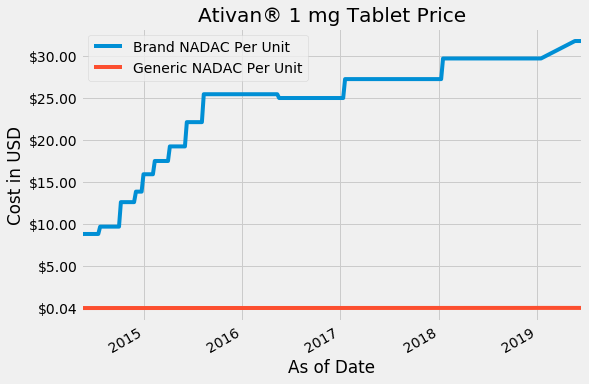

In [20]:
#plotting
plt.style.use('fivethirtyeight')
ax = ativan_1mg.plot(x='As of Date'
                , y=['Brand NADAC Per Unit', 'Generic NADAC Per Unit']
                , yticks=(.04, 5, 10, 15, 20, 25, 30)
                , figsize=(8,6))
plt.title('Ativan® 1 mg Tablet Price')
plt.ylabel('Cost in USD')
#formating the ticks to USD
formatter = ticker.FormatStrFormatter('$%1.2f')
ax.yaxis.set_major_formatter(formatter)

In [21]:
ativan_1mg.describe()

,NDC,Brand NADAC Per Unit,Generic NADAC Per Unit,name/gen,name_gen_dif
count,250.0,250.000000,250.000000,250.000000,250.000000
mean,187006410.0,24.041442,0.025672,960.407730,24.015770
std,0.0,6.234254,0.004619,287.138296,6.233824
min,187006410.0,8.785940,0.021040,337.017912,8.761500
25%,187006410.0,22.160160,0.022820,772.023237,22.135080
50%,187006410.0,25.484190,0.024290,1036.079470,25.460350
75%,187006410.0,27.284530,0.025880,1162.527908,27.262560
max,187006410.0,31.818480,0.041720,1396.906529,31.780030


###EPIPEN

In [0]:
#Make Epipen subset
epipen = df[df['NDC Description'].str.contains('EPIPEN')]

In [23]:
epipen.head(1)

,NDC Description,NDC,Brand NADAC Per Unit,Effective_Date,Pricing_Unit,Pharmacy_Type_Indicator,OTC,Explanation_Code,Classification_for_Rate_Setting,Generic NADAC Per Unit,Corresponding_Generic_Drug_Effective_Date,As of Date,name/gen,name_gen_dif
2442,EPIPEN 2-PAK 0.3 MG AUTO-INJCT,49502050002,292.22758,2018-06-20,EA,C/I,N,2,B,143.52572,11/21/2018 12:00:00 AM,2018-12-12,2.036064,148.70186


In [24]:
epipen['NDC Description'].value_counts()

EPIPEN JR 2-PAK 0.15 MG INJCTR    290
EPIPEN 2-PAK 0.3 MG AUTO-INJCT    288
EPIPEN JR 0.15 MG AUTO-INJECTR     95
EPIPEN 0.3 MG AUTO-INJECTOR        95
Name: NDC Description, dtype: int64

In [0]:
#Jr 2-pak has the most data points
df2 = epipen[epipen['NDC Description'] == 'EPIPEN JR 2-PAK 0.15 MG INJCTR']

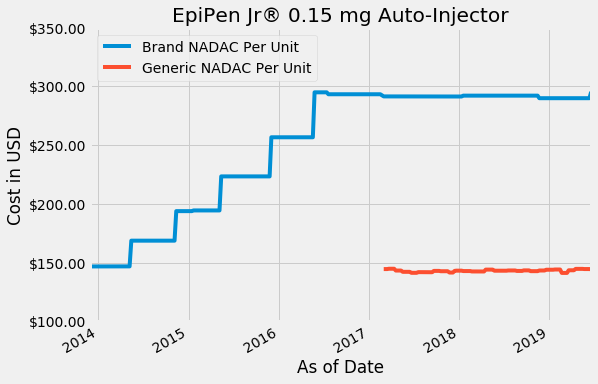

In [26]:
plt.style.use('fivethirtyeight')
ax = df2.plot(x='As of Date'
                , y=['Brand NADAC Per Unit', 'Generic NADAC Per Unit']
                , ylim=[100, 350]
                , figsize=(8,6))
plt.legend(loc='upper left')
plt.title('EpiPen Jr® 0.15 mg Auto-Injector')
plt.ylabel('Cost in USD')
#Format to USD
ax.yaxis.set_major_formatter(formatter)

### Pie Chart

In [0]:
#Convert to Date Time
master_df['As of Date'] = pd.to_datetime(master_df['As of Date'], infer_datetime_format=True)

In [28]:
#Taking only the lastest report
present_df = master_df[master_df['As of Date'] == '2019-06-19']
present_df.shape

(24796, 12)

In [29]:
#The null values are medications without generics. Those with values
#have a generic availible
present_df['Corresponding_Generic_Drug_NADAC_Per_Unit'].isnull().value_counts()

True     23852
False      944
Name: Corresponding_Generic_Drug_NADAC_Per_Unit, dtype: int64

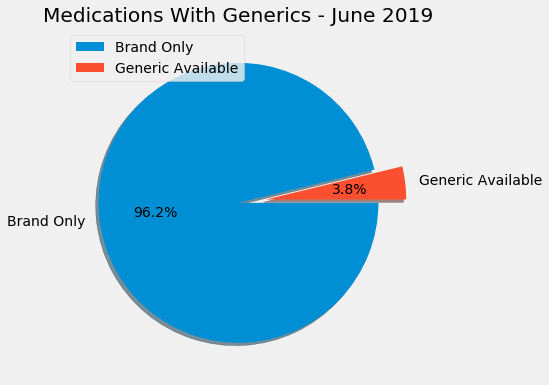

In [30]:
values = [ 23852, 944]
colors = ['#008FD5', '#FC4F30']
labels = ['Brand Only', 'Generic Available']
explode = (0, 0.2)
fig = plt.figure(figsize=(8,6))
plt.pie(values, colors=colors, labels=labels,explode=explode, autopct='%1.1f%%' ,counterclock=False, shadow=True)
plt.title('Medications With Generics - June 2019')
plt.legend(labels,loc='upper left')
plt.show()

###Box plot

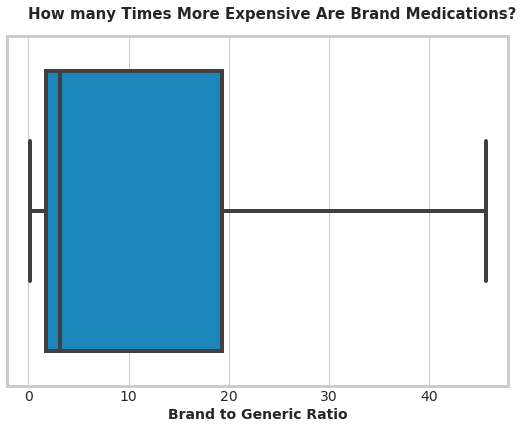

In [31]:
sns.set_style('whitegrid')
fig = plt.figure(figsize=(8,6))
ax = sns.boxplot(x=df['name/gen'], showfliers=False)
ax.text(0, -.55,'How many Times More Expensive Are Brand Medications?', fontsize=15, fontweight='bold')
plt.xlabel('Brand to Generic Ratio', fontsize=14, fontweight='bold');

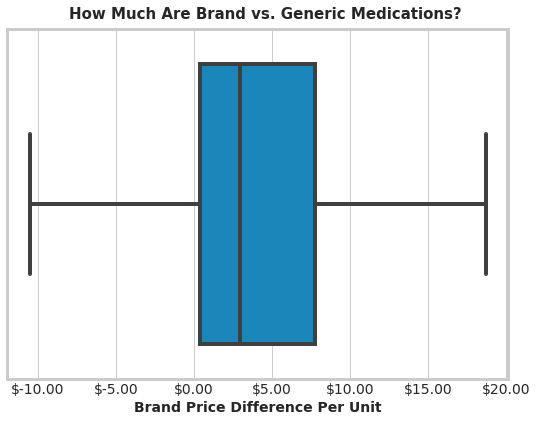

In [32]:
sns.set_style('whitegrid')
fig = plt.figure(figsize=(8,6))
ax = sns.boxplot(x=df['name_gen_dif'], showfliers=False)
ax.text(-8, -.53,'How Much Are Brand vs. Generic Medications?', fontsize=15, fontweight='bold')
plt.xlabel('Brand Price Difference Per Unit', fontsize=14, fontweight='bold')
ax.xaxis.set_major_formatter(formatter)

### Cheaper Subset

In [0]:
#taking a look at those brands that are cheaper than their generics.
cheaper = df[df['name/gen'] <= 1]

In [34]:
cheaper.sort_values('As of Date', ascending=False)

,NDC Description,NDC,Brand NADAC Per Unit,Effective_Date,Pricing_Unit,Pharmacy_Type_Indicator,OTC,Explanation_Code,Classification_for_Rate_Setting,Generic NADAC Per Unit,Corresponding_Generic_Drug_Effective_Date,As of Date,name/gen,name_gen_dif
686647,PACERONE 400 MG TABLET,245014530,1.83853,2019-01-23,EA,C/I,N,"4, 6",B-ANDA,2.99220,06/19/2019 12:00:00 AM,2019-06-19,0.614441,-1.15367
686377,CARNITOR 100 MG/ML ORAL SOLN,54482014508,0.27455,2019-01-01,ML,C/I,N,"4, 5",B,0.29782,06/19/2019 12:00:00 AM,2019-06-19,0.921866,-0.02327
689666,LORCET HD 10-325 MG TABLET,51862058701,0.09554,2019-04-17,EA,C/I,N,"4, 6",B-ANDA,0.11815,06/19/2019 12:00:00 AM,2019-06-19,0.808633,-0.02261
686923,PACERONE 100 MG TABLET,245014401,1.74139,2019-04-17,EA,C/I,N,"4, 6",B-ANDA,2.13677,06/19/2019 12:00:00 AM,2019-06-19,0.814964,-0.39538
676312,DERMOTIC OIL 0.01% EAR DROPS,68791010320,1.36081,2018-11-21,ML,C/I,N,"2, 5",B,3.00482,06/19/2019 12:00:00 AM,2019-06-19,0.452876,-1.64401
676695,KLOR-CON 20 MEQ PACKET,245036001,4.91047,2019-06-19,EA,C/I,N,"1, 6",B-ANDA,5.87166,06/19/2019 12:00:00 AM,2019-06-19,0.836300,-0.96119
680965,LORCET HD 10-325 MG TABLET,51862058705,0.09554,2019-04-17,EA,C/I,N,"4, 6",B-ANDA,0.11815,06/19/2019 12:00:00 AM,2019-06-19,0.808633,-0.02261
677560,RETIN-A 0.05% CREAM,187516245,2.01125,2019-03-01,GM,C/I,N,"2, 5",B,2.79248,06/19/2019 12:00:00 AM,2019-06-19,0.720238,-0.78123
690709,PACERONE 400 MG TABLET,245014501,1.83853,2019-01-23,EA,C/I,N,"4, 6",B-ANDA,2.99220,06/19/2019 12:00:00 AM,2019-06-19,0.614441,-1.15367
692487,KLOR-CON 20 MEQ PACKET,245036030,4.91047,2019-06-19,EA,C/I,N,"1, 6",B-ANDA,5.87166,06/19/2019 12:00:00 AM,2019-06-19,0.836300,-0.96119
